In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from cooling_class import get_cooling_object
from latexify import latexify
import time
import jax
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5
import equinox as eqx
import optax
import pysr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
jax.devices()

[CpuDevice(id=0)]

In [3]:
g_code_units = 0.03741114852 # 1e-8 cm/s^2
cooler = get_cooling_object()

In [4]:
# input in code units
def get_sol_jax(r, steps=1000):
    cool_fac = 100
    g        = g_code_units
    chi      = 100
    t_end    = 225
    c0       = 1.0
    rho_cold = 100.0
    m0       = rho_cold*(4/3)*jnp.pi*r**3
    cshot    = 1.5*jnp.sqrt(chi/100)
    
    f_A      = 0.234
    tgrow0   = f_A*150*jnp.power(cool_fac/5,-0.25)*(chi/100)*r**0.75

    @jax.jit
    def falling_cloud(t,y,args):
        z,v,m = y
        
        rampup = 5*jnp.sqrt(chi)*r/z
        weight = jnp.where(rampup>1,rampup,1)
        tgrow = weight*tgrow0*jnp.power(m/m0,1/6)*jnp.power(1.5/jnp.where(v<cshot,v,cshot),0.6)

        dzdt = v
        dvdt = -(v/tgrow) + g - ((c0)/(2*chi))*(1/r)*v**2
        dmdt = m/tgrow

        return dzdt, dvdt, dmdt

    term   = ODETerm(falling_cloud)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, t_end, steps))
    sol    = diffeqsolve(term, solver, 0, t_end, 0.1, (1e-20,1e-20,m0), args=(), saveat=saveat)
    
    return jnp.array(sol.ys)

In [5]:
def xavier_init(weight: jax.Array, key: jax.random.PRNGKey) -> jax.Array:
  out, in_ = weight.shape
  limit = jnp.sqrt(6.0 / (in_ + out))
  return jax.random.uniform(key, shape=(out, in_), minval=-limit, maxval=limit)

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]

  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

In [6]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=1,
            width_size=width_size,
            depth=depth,
            activation=jnn.gelu,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(jnp.array([y[0],y[1],jnp.log10(y[2])]))

In [7]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        model = Func(data_size, width_size, depth, key=key)
        model = init_linear_weight(model, xavier_init, key)
        self.func = model

    def __call__(self, ts, y0, r):
        z_norm   = 0.001
        m_norm   = 0.1
        t_norm   = 1./225
        g        = g_code_units
        cool_fac = 100
        chi      = 100
        c0       = 1.0
        rho_cold = 100.0
        cshot    = 1.5*jnp.sqrt(chi/100)
        f_A      = 0.234
        tgrow0   = t_norm*f_A*150*jnp.power(cool_fac/5,-0.25)*(chi/100)*r**0.75
        
        @jax.jit
        def falling_cloud(t,y,args):
            z,v,m = y
                   
            weight = self.func
            tgrow = (1/weight(t,y,args)[0])*tgrow0*jnp.power(m/m_norm/(r/3)**3, 1/6)\
                    *jnp.power(1.5/jnp.where(v<cshot,v,cshot),0.6)

            dzdt = v*z_norm/t_norm
            dvdt = -v/tgrow + g/t_norm - ((c0)/(2*chi))*(1/r)*jnp.power(v,2)/t_norm
            dmdt = m/tgrow

            return jnp.array([dzdt, dvdt, dmdt])
        
        term   = ODETerm(falling_cloud)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        solution = diffeqsolve(term, solver, 
                               ts[0], ts[-1], ts[1]-ts[0], y0, args=jnp.log10(r), 
                               stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-8), 
                               max_steps=16**5,
                               saveat=saveat)

        return solution

In [8]:
# Use my weight function as the training target to test
rs = jnp.array([3,1,0.3,1.73,0.55,10,5.5]) # Training Set
rsT = jnp.array([0.7,0.4,0.8,2,4,8])       # Validation Set
rsT2 = jnp.array([0.1]) # OOD Test

length_size = 1000
t_end       = 225

t_range     = jnp.linspace(0, t_end, length_size)
ts          = jnp.linspace(0, 1.0, length_size)

training_sol = jax.vmap(get_sol_jax)(rs)
test_sol     = jax.vmap(get_sol_jax)(rsT)
test_sol2    = jax.vmap(get_sol_jax)(rsT2)

def normalize(yi):
    return jnp.swapaxes(jnp.array([yi[1], yi[0]/1000, yi[2]/training_sol[0,2,0]/10]),0,1)

ys = jax.vmap(normalize,0)(training_sol)
ysT = jax.vmap(normalize,0)(test_sol) 
ysT2 = jax.vmap(normalize,0)(test_sol2)   

In [9]:
def main(make_plot=False):
    data_size  = 3
    seed       = 5678
    depth      = 3
    width_size = 32

    key = jr.PRNGKey(seed)
    _, model_key, _ = jr.split(key, 3)
    model = NeuralODE(data_size, width_size, depth, key=model_key)

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi, ri):
        y_pred = jax.vmap(model, in_axes=(None, 0, 0))(ti, yi[:, 0], ri)
        (batch_size, y_length, _) = jnp.shape(y_pred.ys)
        focus  = jnp.linspace(1,0.1,y_length)
        wi     = jax.lax.dynamic_slice(yi, (0,0,2), (batch_size,y_length,1))
        w_pred = jax.lax.dynamic_slice(y_pred.ys, (0,0,2), (batch_size,y_length,1))
        return jnp.mean(((jnp.log10(wi) - jnp.log10(w_pred)) ** 2)*focus[:,None])
    
    @eqx.filter_jit
    def validation_loss(model, ti, yi, ri):
        y_pred = jax.vmap(model, in_axes=(None, 0, 0))(ti, yi[:, 0], ri)
        (batch_size, y_length, _) = jnp.shape(y_pred.ys)
        focus  = jnp.linspace(1,0.1,y_length)
        wi     = jax.lax.dynamic_slice(yi, (0,0,2), (batch_size,y_length,1))
        w_pred = jax.lax.dynamic_slice(y_pred.ys, (0,0,2), (batch_size,y_length,1))
        return jnp.mean(((jnp.log10(wi) - jnp.log10(w_pred)) ** 2)*focus[:,None])
    
    @eqx.filter_jit
    def make_step(ti, yi, ri, model, opt_state):
        loss, grads = grad_loss(model, ti, yi, ri)
        updates, opt_state = optim.update(grads, opt_state,params=model)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    
    print_every     = 100
    lr_strategy     = (2e-3,3e-3) 
    steps_strategy  = (1300,3500)
    length_strategy = (0.2,1) 
    
    losses = []
    accuracies = []
    plot_count = 0

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adamw(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length), :]
        for step in range(steps):
            start = time.time()
            loss, model, opt_state = make_step(_ts, _ys, rs, model, opt_state)
            end = time.time()
            
            val_loss = validation_loss(model, ts, ysT, rsT)

            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Accuracy: {val_loss}, Computation time: {end - start}")
                losses.append(loss)
                accuracies.append(val_loss)
                
                if make_plot:
                    plt.figure()
                    ax = plt.gca()
                    for i in [0,1,3,4]:
                        sol_current = model(ts, ysT[i,0],  rsT[i])
                        lbl1 = "Truth" if i == 0 else None
                        lbl2 = "Prediction" if i == 0 else None
                        plt.plot(t_range, ysT[i,:,2]/ysT[i,0,2],alpha=0.5,label=lbl1,c='C1',ls='--')
                        plt.plot(sol_current.ts*225, sol_current.ys[:,2]/sol_current.ys[0,2],
                                 alpha=0.5,label=lbl2,c='C2')
                    plt.text(.02, .98, f'Length Strategy: {lr} \nStep {step}', 
                             ha='left', va='top', transform=ax.transAxes)
                    plt.yscale('log')
                    plt.xlim([0,t_end])
                    plt.ylim([0.05,10000])
                    plt.xlabel('t (Myr)')
                    plt.ylabel(r'm/m$_0$')
                    plt.legend(frameon=False,handlelength=1.8, loc='lower right',ncols=2)
                    plt.tight_layout()
                    plt.savefig(f'./learning/mock{plot_count:03}.png',dpi=150)
                    plot_count += 1
                    plt.close()
 
    return model, losses, accuracies

In [10]:
model_jax_nn, model_loss , model_accu = main(make_plot=False)

Step: 0, Loss: 0.0019152375170961022, Accuracy: 0.13229969143867493, Computation time: 29.5286865234375
Step: 100, Loss: 0.00020695262355729938, Accuracy: 0.054767027497291565, Computation time: 0.018917560577392578
Step: 200, Loss: 0.00013188367302063853, Accuracy: 0.05036737024784088, Computation time: 0.01943516731262207
Step: 300, Loss: 0.0001039341077557765, Accuracy: 0.07356291264295578, Computation time: 0.019546985626220703
Step: 400, Loss: 9.380538540426642e-05, Accuracy: 0.05682223290205002, Computation time: 0.020386695861816406
Step: 500, Loss: 8.46626644488424e-05, Accuracy: 0.039935097098350525, Computation time: 0.020061731338500977
Step: 600, Loss: 7.390477549051866e-05, Accuracy: 0.02863885648548603, Computation time: 0.020325899124145508
Step: 700, Loss: 6.632637814618647e-05, Accuracy: 0.022220870479941368, Computation time: 0.020582199096679688
Step: 800, Loss: 5.874474663869478e-05, Accuracy: 0.016760459169745445, Computation time: 0.020467519760131836
Step: 900, L

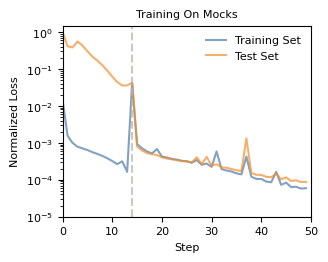

In [12]:
latexify(columns=1)
plt.figure()
plt.yscale('log')
plt.plot(np.array(model_loss)/model_accu[0],alpha=0.7,label='Training Set')
plt.plot(np.array(model_accu)/model_accu[0],alpha=0.7,label='Test Set')
plt.vlines(14,1e-5,1.5,alpha=0.7,color='C9',ls='--')
plt.ylabel('Normalized Loss')
plt.xlabel('Step')
plt.xlim(0,50)
plt.ylim(1e-5,1.5)
plt.legend(frameon=False,handlelength=1.8)
plt.title('Training On Mocks')
plt.tight_layout()
plt.savefig('./plots/loss_mocks.png',dpi=150)
plt.savefig('./plots/loss_mocks.pdf',dpi=150)
plt.show()

In [13]:
sol_jax_nn1 = model_jax_nn(ts, ys[0,0],  rs[0])
sol_jax_nn2 = model_jax_nn(ts, ys[1,0],  rs[1])
sol_jax_nn3 = model_jax_nn(ts, ys[2,0],  rs[2])
sol_jax_nnT = model_jax_nn(ts, ysT[0,0], rsT[0])
sol_jax_nnT2 = model_jax_nn(ts, ysT2[0,0], rsT2[0])

In [14]:
def get_learned_weights(model_nn, sol_nn,r):
    return jax.vmap(model_nn.func, in_axes=(0, 0, None))(sol_nn.ts,sol_nn.ys,jnp.log10(r))

learn_weights1 = get_learned_weights(model_jax_nn, sol_jax_nn1, rs[0])
learn_weights2 = get_learned_weights(model_jax_nn, sol_jax_nn2, rs[1])
learn_weights3 = get_learned_weights(model_jax_nn, sol_jax_nn3, rs[2])
learn_weightsT = get_learned_weights(model_jax_nn, sol_jax_nnT, rsT[0])
learn_weightsT2 = get_learned_weights(model_jax_nn, sol_jax_nnT2, rsT2[0])

In [15]:
def get_weight(r,z):
    chi = 100
    rampup = z/r/5/jnp.sqrt(chi)
    weight = jnp.where(rampup<1,rampup,1)
    return weight

actual_weights1 = get_weight(rs[0],  1000*ys[0,:,1])
actual_weights2 = get_weight(rs[1],  1000*ys[1,:,1])
actual_weights3 = get_weight(rs[2],  1000*ys[2,:,1])
actual_weightsT = get_weight(rsT[0], 1000*ysT[0,:,1]) 
actual_weightsT2 = get_weight(rsT2[0], 1000*ysT2[0,:,1]) 

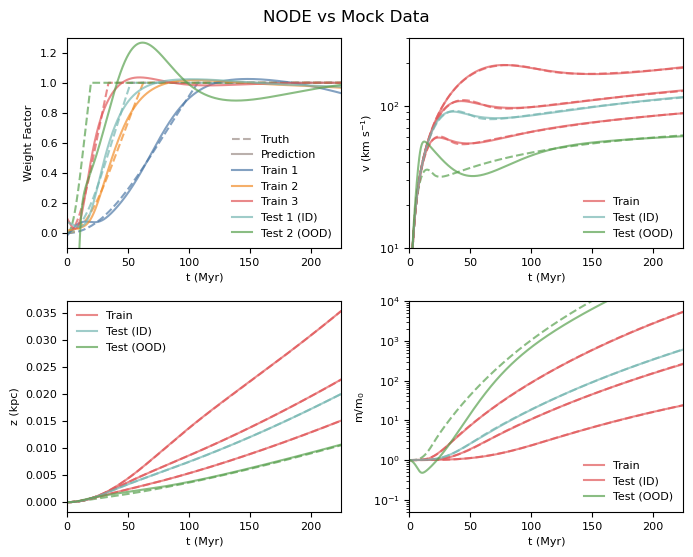

In [16]:
 # Create plots
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

axs[0][0].plot(-100, -100, c='C9', ls= '--', label='Truth')
axs[0][0].plot(-100, -100, c='C9', ls= '-', label='Prediction')
axs[0][0].plot(t_range, actual_weights1, c='C0', alpha=0.7,ls = '--')
axs[0][0].plot(t_range, actual_weights2, c='C1', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weights3, c='C2', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weightsT, c='C3', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weightsT2, c='C4', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, learn_weights1,  c='C0', alpha=0.7, ls = '-',  label=r'Train 1')
axs[0][0].plot(t_range, learn_weights2,  c='C1', alpha=0.7, ls = '-',  label=r'Train 2') 
axs[0][0].plot(t_range, learn_weights3,  c='C2', alpha=0.7, ls = '-',  label=r'Train 3') 
axs[0][0].plot(t_range, learn_weightsT,  c='C3', alpha=0.7, ls = '-',  label=r'Test 1 (ID)') 
axs[0][0].plot(t_range, learn_weightsT2,  c='C4', alpha=0.7, ls = '-', label=r'Test 2 (OOD)') 
axs[0][0].set_ylabel('Weight Factor')
axs[0][0].set_xlabel('t (Myr)')
axs[0][0].set_xlim([0,t_end])
axs[0][0].set_ylim([-0.1,1.3])
axs[0][0].legend(frameon=False,handlelength=1.8, loc='lower right', ncols=1)

axs[0][1].plot(t_range, 100*ys[0,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(t_range, 100*ys[1,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(t_range, 100*ys[2,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(t_range, 100*ysT[0,:,0],alpha=0.7,c='C3',ls='--')
axs[0][1].plot(t_range, 100*ysT2[0,:,0],alpha=0.7,c='C4',ls='--')
axs[0][1].plot(t_range, sol_jax_nn1.ys[:,1]*100,alpha=0.7,label=r'Train',c='C2')
axs[0][1].plot(t_range, sol_jax_nn2.ys[:,1]*100,alpha=0.7,c='C2')
axs[0][1].plot(t_range, sol_jax_nn3.ys[:,1]*100,alpha=0.7,c='C2')
axs[0][1].plot(t_range, sol_jax_nnT.ys[:,1]*100,alpha=0.7,label=r'Test (ID)',c='C3')
axs[0][1].plot(t_range, sol_jax_nnT2.ys[:,1]*100,alpha=0.7,label=r'Test (OOD)',c='C4')
axs[0][1].set_xlim([0,t_end])
axs[0][1].set_yscale('log')
axs[0][1].set_ylim([0.1*100, 3*100])
axs[0][1].set_xlabel('t (Myr)')
axs[0][1].set_ylabel(r'v (km s$^{-1}$)')
axs[0][1].legend(frameon=False,handlelength=1.8,loc='lower right',ncols=1)

axs[1][0].plot(t_range, ys[0,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(t_range, ys[1,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(t_range, ys[2,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(t_range, ysT[0,:,1]/10,alpha=0.7,c='C3',ls='--')
axs[1][0].plot(t_range, ysT2[0,:,1]/10,alpha=0.7,c='C4',ls='--')
axs[1][0].plot(t_range, sol_jax_nn1.ys[:,0]/10,alpha=0.7,label="Train",c='C2')
axs[1][0].plot(t_range, sol_jax_nn2.ys[:,0]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, sol_jax_nn3.ys[:,0]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, sol_jax_nnT.ys[:,0]/10,alpha=0.7,label="Test (ID)",c='C3')
axs[1][0].plot(t_range, sol_jax_nnT2.ys[:,0]/10,alpha=0.7,label="Test (OOD)",c='C4')
axs[1][0].set_xlim([0,t_end])
axs[1][0].set_xlabel('t (Myr)')
axs[1][0].set_ylabel('z (kpc)')
axs[1][0].legend(frameon=False,handlelength=1.8, loc='upper left',ncols=1)

axs[1][1].plot(t_range, ys[0,:,2]/ys[0,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(t_range, ys[1,:,2]/ys[1,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(t_range, ys[2,:,2]/ys[2,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(t_range, ysT[0,:,2]/ysT[0,0,2],alpha=0.7,c='C3',ls='--')
axs[1][1].plot(t_range, ysT2[0,:,2]/ysT2[0,0,2],alpha=0.7,c='C4',ls='--')
axs[1][1].plot(t_range, sol_jax_nn1.ys[:,2]/sol_jax_nn1.ys[0,2],alpha=0.7,label="Train",c='C2')
axs[1][1].plot(t_range, sol_jax_nn2.ys[:,2]/sol_jax_nn2.ys[0,2],alpha=0.7,label="Test (ID)",c='C2')
axs[1][1].plot(t_range, sol_jax_nn3.ys[:,2]/sol_jax_nn3.ys[0,2],alpha=0.7,c='C2')
axs[1][1].plot(t_range, sol_jax_nnT.ys[:,2]/sol_jax_nnT.ys[0,2],alpha=0.7,c='C3')
axs[1][1].plot(t_range, sol_jax_nnT2.ys[:,2]/sol_jax_nnT2.ys[0,2],alpha=0.7,label="Test (OOD)",c='C4')

axs[1][1].set_yscale('log')
axs[1][1].set_xlim([0,t_end])
axs[1][1].set_ylim([0.05,10000])
axs[1][1].set_xlabel('t (Myr)')
axs[1][1].set_ylabel(r'm/m$_0$')
axs[1][1].legend(frameon=False,handlelength=1.8, loc='lower right',ncols=1)

plt.suptitle("NODE vs Mock Data")
plt.tight_layout()
plt.savefig('./plots/node_mocks.png',dpi=150)
plt.savefig('./plots/node_mocks.pdf',dpi=150)
plt.show()

In [17]:
def get_weights(r_test):
    stps = 100
    test_sol = get_sol_jax(r_test, steps=stps)
    ysT = normalize(test_sol)
    sol_jax_test = model_jax_nn(jnp.linspace(0, 1.0, stps), ysT[0], r_test)
    actual_weightsT = get_weight(r_test, 1000*ysT[:,1]) 
    learn_weightsT  = get_learned_weights(model_jax_nn, sol_jax_test, r_test)
    return jnp.column_stack((sol_jax_test.ys,r_test*jnp.ones(stps))) , learn_weightsT, actual_weightsT

sr_input, weights_input, actual_weights = jax.vmap(get_weights)(np.logspace(-0.5,1,10))
shape = jnp.shape(sr_input)
sr_input = jnp.reshape(sr_input,(shape[0]*shape[1],shape[2]))
weights_input = jnp.reshape(weights_input,(shape[0]*shape[1],1))
actual_weights = jnp.reshape(actual_weights,(shape[0]*shape[1],1))

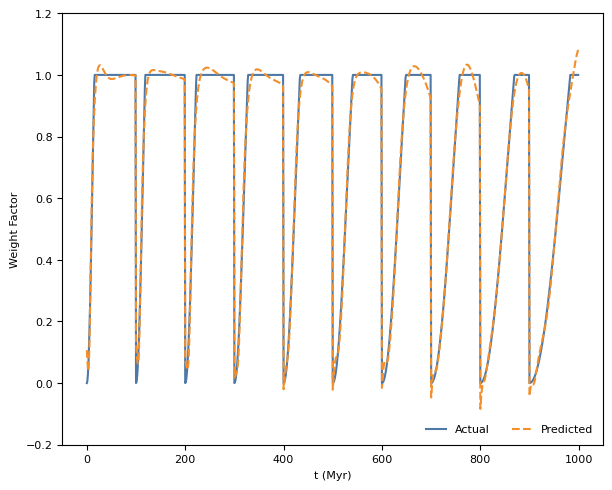

In [18]:
plt.plot(actual_weights, label='Actual')
plt.plot(weights_input, ls='--', label='Predicted')
plt.ylabel('Weight Factor')
plt.xlabel('t (Myr)')
plt.ylim(-0.2,1.2)
plt.legend(frameon=False,handlelength=1.8, loc='lower right',ncols=2)
plt.show()

In [172]:
model = pysr.PySRRegressor(
    niterations=100,
    populations=100,
    binary_operators= ["+","-","*","/","^","min"],
    unary_operators=["log","exp"],
    constraints={"/": (-1, 9),"^": (9, 1)},
    nested_constraints={"min": {"min": 0}},
    weight_optimize=0.01,
    bumper=True,
    verbosity=0,
    maxdepth=10,
    model_selection='score',
    temp_equation_file=True,
)
start = time.time()
model.fit(sr_input, weights_input,X_units=["m", "m/s", "kg","m"])
end = time.time()
print(f"Computation time: {end - start}")
print(model)

Computation time: 420.13707208633423
PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                         0.73723996   
	1         7.514232e-08                                   exp(-0.30474693)   
	2         2.557998e-01                                    0.59502304 + x0   
	3         6.106957e-01                             exp(-0.015646888 / x0)   
	4         7.895167e-01                      exp((x3 * -0.011280199) / x0)   
	5   >>>>  2.900173e+00              min(0.9948293, 19.942173 * (x0 / x3))   
	6         1.716885e-02       min(20.664331 * (x0 / (x3 + x0)), 0.9950066)   
	7         6.919280e-03  min(0.99500537, ((x0 / 0.04866166) + 0.0059061...   
	8         2.414955e-03  min(0.99595946, ((x0 / 0.047106225) - -0.00436...   
	9         2.244016e-02  min(0.9963578, (x0 / 0.047852706) / (x3 + (x0 ...   
	10        2.044873e-03  min(0.9961344, ((x0 / 0.048339386) + 0.0044423...  

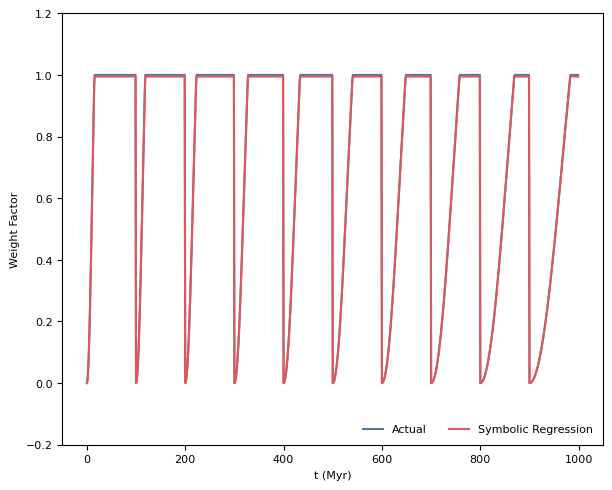

In [173]:
plt.plot(actual_weights, label='Actual')
plt.plot(model.predict(sr_input), c='C2', label='Symbolic Regression')
plt.ylabel('Weight Factor')
plt.xlabel('t (Myr)')
plt.ylim(-0.2,1.2)
plt.legend(frameon=False,handlelength=1.8, loc='lower right',ncols=2)
plt.show()

In [19]:
# input in code units
def get_sol_SR(r, steps=1000):
    cool_fac = 100
    g        = g_code_units
    chi      = 100
    t_end    = 225
    c0       = 1.0
    rho_cold = 100.0
    m0       = rho_cold*(4/3)*jnp.pi*r**3
    cshot    = 1.5*jnp.sqrt(chi/100)
    
    f_A      = 0.234
    tgrow0   = f_A*150*jnp.power(cool_fac/5,-0.25)*(chi/100)*r**0.75

    @jax.jit
    def falling_cloud(t,y,args):
        z,v,m = y
        
        rampup = (z/r)*19.942173*0.001
        weight = jnp.where(rampup<0.9948293,rampup,0.9948293)
        tgrow = 1./weight*tgrow0*jnp.power(m/m0,1/6)*jnp.power(1.5/jnp.where(v<cshot,v,cshot),0.6)

        dzdt = v
        dvdt = -(v/tgrow) + g - ((c0)/(2*chi))*(1/r)*v**2
        dmdt = m/tgrow

        return dzdt, dvdt, dmdt

    term   = ODETerm(falling_cloud)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, t_end, steps))
    sol    = diffeqsolve(term, solver, 0, t_end, 0.1, (1e-20,1e-20,m0), args=(), saveat=saveat)
    
    return jnp.array(sol.ys)

In [20]:
training_sol_SR = jax.vmap(get_sol_SR)(rs)
test_sol_SR     = jax.vmap(get_sol_SR)(rsT)
test_sol2_SR    = jax.vmap(get_sol_SR)(rsT2)

ys_SR = jax.vmap(normalize,0)(training_sol_SR)
ysT_SR = jax.vmap(normalize,0)(test_sol_SR) 
ysT2_SR = jax.vmap(normalize,0)(test_sol2_SR) 

def get_weight_SR(r,z):
    chi = 100
    rampup = (z/r)*19.942173*0.001
    weight = jnp.where(rampup<0.9948293,rampup,0.9948293)
    return weight

actual_weights1_SR = get_weight_SR(rs[0],  1000*ys_SR[0,:,1])
actual_weights2_SR = get_weight_SR(rs[1],  1000*ys_SR[1,:,1])
actual_weights3_SR = get_weight_SR(rs[2],  1000*ys_SR[2,:,1])
actual_weightsT_SR = get_weight_SR(rsT[0], 1000*ysT[0,:,1]) 
actual_weightsT2_SR = get_weight_SR(rsT2[0], 1000*ysT2[0,:,1]) 

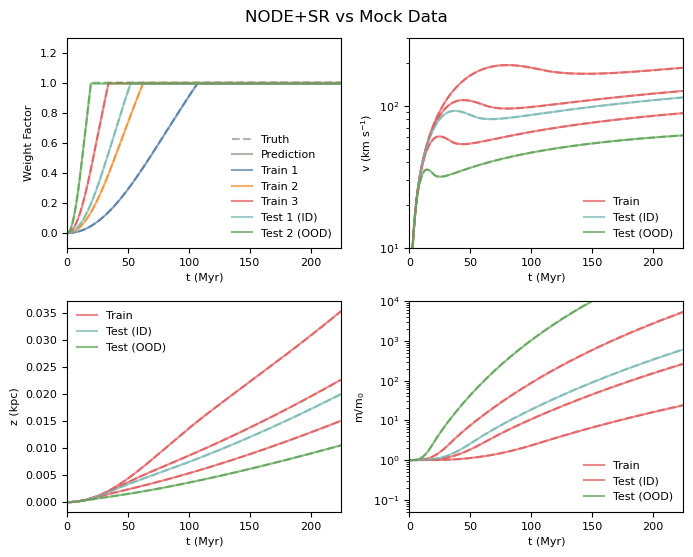

In [21]:
 # Create plots
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

axs[0][0].plot(-100, -100, c='C9', ls= '--', label='Truth')
axs[0][0].plot(-100, -100, c='C9', ls= '-', label='Prediction')
axs[0][0].plot(t_range, actual_weights1, c='C0', alpha=0.7,ls = '--')
axs[0][0].plot(t_range, actual_weights2, c='C1', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weights3, c='C2', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weightsT, c='C3', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weightsT2, c='C4', alpha=0.7,ls = '--') 
axs[0][0].plot(t_range, actual_weights1_SR,  c='C0', alpha=0.7, ls = '-',  label=r'Train 1')
axs[0][0].plot(t_range, actual_weights2_SR,  c='C1', alpha=0.7, ls = '-',  label=r'Train 2') 
axs[0][0].plot(t_range, actual_weights3_SR,  c='C2', alpha=0.7, ls = '-',  label=r'Train 3') 
axs[0][0].plot(t_range, actual_weightsT_SR,  c='C3', alpha=0.7, ls = '-',  label=r'Test 1 (ID)') 
axs[0][0].plot(t_range, actual_weightsT2_SR,  c='C4', alpha=0.7, ls = '-', label=r'Test 2 (OOD)') 
axs[0][0].set_ylabel('Weight Factor')
axs[0][0].set_xlabel('t (Myr)')
axs[0][0].set_xlim([0,t_end])
axs[0][0].set_ylim([-0.1,1.3])
axs[0][0].legend(frameon=False,handlelength=1.8, loc='lower right', ncols=1)

axs[0][1].plot(t_range, 100*ys[0,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(t_range, 100*ys[1,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(t_range, 100*ys[2,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(t_range, 100*ysT[0,:,0],alpha=0.7,c='C3',ls='--')
axs[0][1].plot(t_range, 100*ysT2[0,:,0],alpha=0.7,c='C4',ls='--')
axs[0][1].plot(t_range, 100*ys_SR[0,:,0],alpha=0.7,label=r'Train',c='C2')
axs[0][1].plot(t_range, 100*ys_SR[1,:,0],alpha=0.7,c='C2')
axs[0][1].plot(t_range, 100*ys_SR[2,:,0],alpha=0.7,c='C2')
axs[0][1].plot(t_range, 100*ysT_SR[0,:,0],alpha=0.7,label=r'Test (ID)',c='C3')
axs[0][1].plot(t_range, 100*ysT2_SR[0,:,0],alpha=0.7,label=r'Test (OOD)',c='C4')
axs[0][1].set_xlim([0,t_end])
axs[0][1].set_yscale('log')
axs[0][1].set_ylim([0.1*100, 3*100])
axs[0][1].set_xlabel('t (Myr)')
axs[0][1].set_ylabel(r'v (km s$^{-1}$)')
axs[0][1].legend(frameon=False,handlelength=1.8,loc='lower right',ncols=1)

axs[1][0].plot(t_range, ys[0,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(t_range, ys[1,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(t_range, ys[2,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(t_range, ysT[0,:,1]/10,alpha=0.7,c='C3',ls='--')
axs[1][0].plot(t_range, ysT2[0,:,1]/10,alpha=0.7,c='C4',ls='--')
axs[1][0].plot(t_range, ys_SR[0,:,1]/10,alpha=0.7,label="Train",c='C2')
axs[1][0].plot(t_range, ys_SR[1,:,1]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, ys_SR[2,:,1]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, ysT_SR[0,:,1]/10,alpha=0.7,label="Test (ID)",c='C3')
axs[1][0].plot(t_range, ysT2_SR[0,:,1]/10,alpha=0.7,label="Test (OOD)",c='C4')
axs[1][0].set_xlim([0,t_end])
axs[1][0].set_xlabel('t (Myr)')
axs[1][0].set_ylabel('z (kpc)')
axs[1][0].legend(frameon=False,handlelength=1.8, loc='upper left',ncols=1)

axs[1][1].plot(t_range, ys[0,:,2]/ys[0,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(t_range, ys[1,:,2]/ys[1,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(t_range, ys[2,:,2]/ys[2,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(t_range, ysT[0,:,2]/ysT[0,0,2],alpha=0.7,c='C3',ls='--')
axs[1][1].plot(t_range, ysT2[0,:,2]/ysT2[0,0,2],alpha=0.7,c='C4',ls='--')
axs[1][1].plot(t_range, ys_SR[0,:,2]/ys_SR[0,0,2],alpha=0.7,label="Train",c='C2')
axs[1][1].plot(t_range, ys_SR[1,:,2]/ys_SR[1,0,2],alpha=0.7,label="Test (ID)",c='C2')
axs[1][1].plot(t_range, ys_SR[2,:,2]/ys_SR[2,0,2],alpha=0.7,c='C2')
axs[1][1].plot(t_range, ysT_SR[0,:,2]/ysT_SR[0,0,2],alpha=0.7,c='C3')
axs[1][1].plot(t_range, ysT2_SR[0,:,2]/ysT2_SR[0,0,2],alpha=0.7,label="Test (OOD)",c='C4')

axs[1][1].set_yscale('log')
axs[1][1].set_xlim([0,t_end])
axs[1][1].set_ylim([0.05,10000])
axs[1][1].set_xlabel('t (Myr)')
axs[1][1].set_ylabel(r'm/m$_0$')
axs[1][1].legend(frameon=False,handlelength=1.8, loc='lower right',ncols=1)

plt.suptitle("NODE+SR vs Mock Data")
plt.tight_layout()
plt.savefig('./plots/node_sr_mocks.png',dpi=150)
plt.savefig('./plots/node_sr_mocks.pdf',dpi=150)
plt.show()